In [ ]:
import os
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Percorso della cartella contenente le immagini
image_folder = "/content/drive/MyDrive/Blastocyst_Dataset/Images"

# Percorso dei file CSV
train_csv_path = "/content/drive/MyDrive/Blastocyst_Dataset/Gardner_train_silver.csv"  # Sostituisci con il file corretto
test_csv_path = "/content/drive/MyDrive/Blastocyst_Dataset/Gardner_test_gold_onlyGardnerScores.csv"    # Sostituisci con il file corretto
clinical_csv_path = "/content/drive/MyDrive/Blastocyst_Dataset/Clincial_annotations.csv"  # Per gli outcome clinici


In [ ]:
import shutil

source_folder = "/content/drive/MyDrive/Blastocyst_Dataset/Images"  # Path to the folder on your Drive
destination_folder = "/content/Blastocyst_Dataset"  # Desired path in /content

shutil.copytree(source_folder, destination_folder)

'/content/Blastocyst_Dataset'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Carica il dataset dal CSV
df_train = pd.read_csv(train_csv_path, sep=';')
df_test = pd.read_csv(test_csv_path, sep=';')
print(df_train.shape)
print(df_test.shape)
print(df_test.head)


(2044, 4)
(300, 5)
<bound method NDFrame.head of            Image  EXP_gold ICM_gold TE_gold Unnamed: 4
0    0004_03.png       2.0        1       1        NaN
1    0005_08.png       3.0        0       0        NaN
2    0008_01.png       2.0        0       0        NaN
3    0011_02.png       0.0       ND      ND        NaN
4    0011_03.png       3.0        1       0        NaN
..           ...       ...      ...     ...        ...
295   833_02.png       NaN      NaN       1        NaN
296   835_05.png       3.0        0     NaN        NaN
297   836_01.png       3.0        2       1        NaN
298   837_01.png       3.0        0       1        NaN
299   837_02.png       2.0        1       2        NaN

[300 rows x 5 columns]>


In [ ]:
print(df_train['ICM_silver'].value_counts())
print(df_train['EXP_silver'].value_counts())
print(df_train['TE_silver'].value_counts())
print(df_test['ICM_gold'].value_counts())
print(df_test['EXP_gold'].value_counts())
print(df_test['TE_gold'].value_counts())

ICM_silver
0    1305
3     391
1     332
2      16
Name: count, dtype: int64
EXP_silver
3    1081
2     429
0     197
1     194
4     143
Name: count, dtype: int64
TE_silver
0    1081
1     525
3     391
2      47
Name: count, dtype: int64
ICM_gold
0     153
1      68
ND     54
2      17
Name: count, dtype: int64
EXP_gold
3.0    153
2.0     86
1.0     31
0.0     23
4.0      5
Name: count, dtype: int64
TE_gold
0     122
1      82
ND     54
2      30
Name: count, dtype: int64


In [ ]:

# Caricamento dataset
df_train = pd.read_csv(train_csv_path, sep=';')
df_test = pd.read_csv(test_csv_path, sep=';')

# Rimuovere eventuali colonne indesiderate
df_train = df_train.loc[:, ~df_train.columns.str.contains('Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('Unnamed')]

# Sostituzione di "ND" con 3
df_test['TE_gold'] = df_test['TE_gold'].replace('ND', 3)  # Sostituisci 'ND' con 3
df_test['TE_gold'] = df_test['TE_gold'].fillna(3).astype(int)  # Riempi NaN con 3 e converti in int

df_test['ICM_gold'] = df_test['ICM_gold'].replace('ND', 3)
df_test['ICM_gold'] = df_test['ICM_gold'].fillna(3).astype(int)

df_test['EXP_gold'] = df_test['EXP_gold'].fillna(0).astype(int)

# Uniformiamo i nomi delle colonne per poter concatenare i DataFrame
df_train.rename(columns={'EXP_silver': 'EXP', 'ICM_silver': 'ICM', 'TE_silver': 'TE'}, inplace=True)
df_test.rename(columns={'EXP_gold': 'EXP', 'ICM_gold': 'ICM', 'TE_gold': 'TE'}, inplace=True)

df_finale = pd.concat([df_train[['Image', 'EXP', 'ICM', 'TE']], df_test[['Image', 'EXP', 'ICM', 'TE']]], ignore_index=True)
# Controllo finale
print(df_finale.head())
print(df_finale.shape)  # Verifica che il numero di righe sia la somma di df_train + df_test


         Image  EXP  ICM  TE
0  0175_05.png    3    1   1
1   420_02.png    3    0   0
2   680_01.png    2    0   0
3   340_03.png    3    0   1
4   571_02.png    0    3   3
(2344, 4)


In [ ]:
df_finale['EXP'] = df_finale['EXP'].replace({1: 0})  # Replace 0 with 1 in the 'EXP' column
df_finale['EXP'] = df_finale['EXP'].replace({2: 1})  # Replace 0 with 1 in the 'EXP' column
df_finale['EXP'] = df_finale['EXP'].replace({3: 2})  # Replace 0 with 1 in the 'EXP' column
df_finale['EXP'] = df_finale['EXP'].replace({4: 3})  # Replace 0 with 1 in the 'EXP' column

In [ ]:
print(df_finale['TE'].value_counts())
print(df_finale['ICM'].value_counts())
print(df_finale['EXP'].value_counts())

TE
0    1203
1     607
3     457
2      77
Name: count, dtype: int64
ICM
0    1458
3     453
1     400
2      33
Name: count, dtype: int64
EXP
2    1234
1     515
0     447
3     148
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Creiamo una colonna che rappresenti le classi combinate
#df_finale['classe_aggregata'] = df_finale['EXP'].astype(str) + "-" + df_finale['ICM'].astype(str) + "-" + df_finale['TE'].astype(str)

# Divisione stratificata (bilanciata sulle classi aggregate)
df_train, df_test = train_test_split(df_finale, test_size=0.2, random_state=42)

# Rimuoviamo la colonna temporanea di classi aggregate
#df_train = df_train.drop(columns=['classe_aggregata'])
#df_test = df_test.drop(columns=['classe_aggregata'])

print(df_train['TE'].value_counts())
print(df_train['ICM'].value_counts())
print(df_train['EXP'].value_counts())
print(df_test['TE'].value_counts())
print(df_test['ICM'].value_counts())
print(df_test['EXP'].value_counts())


TE
0    965
1    482
3    374
2     54
Name: count, dtype: int64
ICM
0    1164
3     371
1     313
2      27
Name: count, dtype: int64
EXP
2    983
1    400
0    364
3    128
Name: count, dtype: int64
TE
0    238
1    125
3     83
2     23
Name: count, dtype: int64
ICM
0    294
1     87
3     82
2      6
Name: count, dtype: int64
EXP
2    251
1    115
0     83
3     20
Name: count, dtype: int64



🔹 Distribuzione PRIMA dell'oversampling/undersampling:
EXP
0    364
1    400
2    983
3    128
Name: count, dtype: int64
ICM
0    1164
1     313
2      27
3     371
Name: count, dtype: int64
TE
0    965
1    482
2     54
3    374
Name: count, dtype: int64

🔹 Distribuzione DOPO l'oversampling/undersampling:
EXP
0    364
1    400
2    983
3    384
Name: count, dtype: int64
ICM
0    1376
1     357
2      27
3     371
Name: count, dtype: int64
TE
0    1153
1     544
2      60
3     374
Name: count, dtype: int64


<ipython-input-13-a38d85c2f0ba>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette=[color], ax=ax)
<ipython-input-13-a38d85c2f0ba>:73: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x=feature, palette=[color], ax=ax)
<ipython-input-13-a38d85c2f0ba>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette=[color], ax=ax)
<ipython-input-13-a38d85c2f0ba>:73: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df, x=feature, palette=[color], ax=

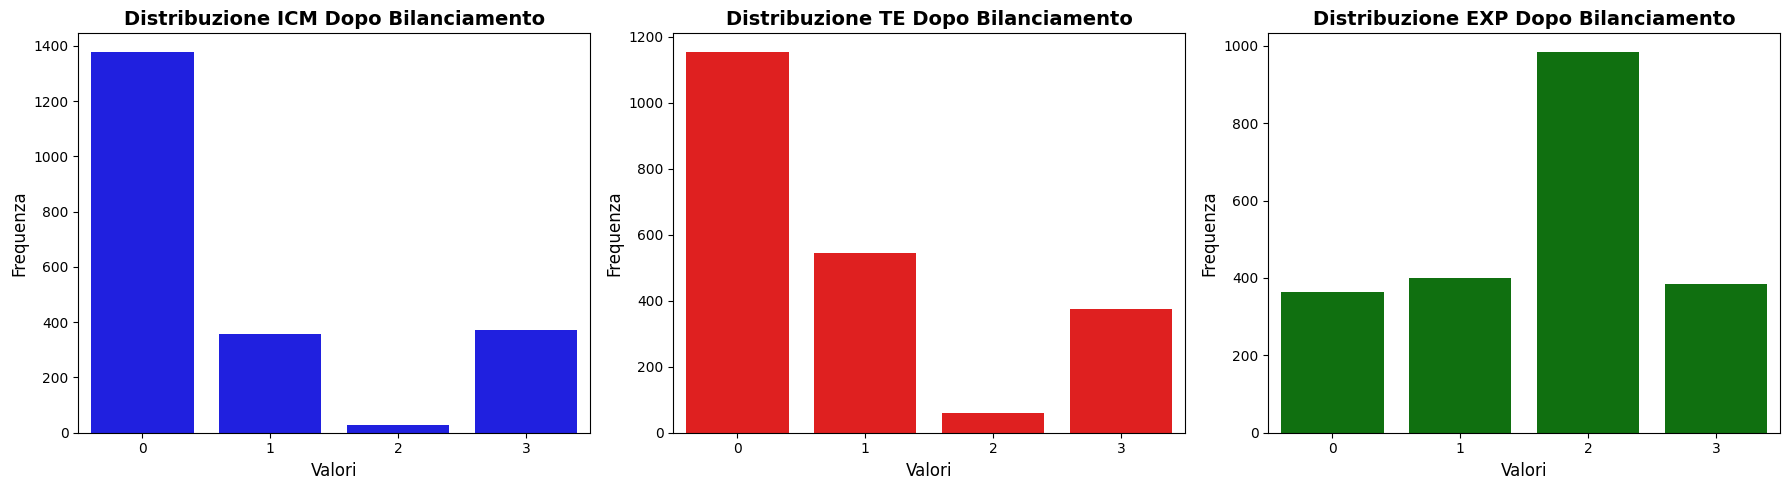

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# 📌 Configurazioni
AUGMENTED_DIR = "/content/Blastocyst_Dataset"
IMAGE_SIZE = (224, 224)
AUGMENT_COUNTS = {"EXP_silver_3": 2}  # Campioni da generare

# 🔹 Creazione cartella per immagini aumentate
os.makedirs(AUGMENTED_DIR, exist_ok=True)

# 🔹 Stampa distribuzione
def print_distribution(title, df):
    print(f"\n🔹 {title}")
    print(df["EXP"].value_counts().sort_index())
    print(df["ICM"].value_counts().sort_index())
    print(df["TE"].value_counts().sort_index())

print_distribution("Distribuzione PRIMA dell'oversampling/undersampling:", df_train)

# 🔹 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# 🔹 Funzione per generare immagini aumentate
def augment_images(df_subset, label_name, augment_count):
    new_samples = []
    for _, row in df_subset.iterrows():
        img_path = os.path.join(image_folder, row["Image"])
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img_array = np.expand_dims(img_to_array(img), axis=0)

        for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
            new_img = array_to_img(batch[0])
            new_img_path = os.path.join(AUGMENTED_DIR, f"{label_name}_aug_{i}_{os.path.basename(img_path)}")
            new_img.save(new_img_path)
            new_samples.append([new_img_path, row["EXP"], row["ICM"], row["TE"]])
            if i + 1 >= augment_count:
                break
    return new_samples

# 🔹 Oversampling delle classi sottorappresentate
new_images = []
new_images += augment_images(df_train[df_train["EXP"] == 3], "exp3", AUGMENT_COUNTS["EXP_silver_3"])



# 🔹 Creazione DataFrame con immagini aumentate
df_augmented = pd.DataFrame(new_images, columns=["Image", "EXP", "ICM", "TE"])


df_train_balanced = pd.concat([df_train, df_augmented], ignore_index=True)

# 🔹 Stampa della distribuzione dopo il bilanciamento
print_distribution("Distribuzione DOPO l'oversampling/undersampling:", df_train_balanced)


# 🔹 Creazione dei grafici per ogni variabile
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_feature_distribution(ax, df, feature, title, color):
    sns.countplot(data=df, x=feature, palette=[color], ax=ax)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Valori", fontsize=12)
    ax.set_ylabel("Frequenza", fontsize=12)

# 🔹 Plot per ogni caratteristica
plot_feature_distribution(axes[0], df_train_balanced, "ICM", "Distribuzione ICM Dopo Bilanciamento", "blue")
plot_feature_distribution(axes[1], df_train_balanced, "TE", "Distribuzione TE Dopo Bilanciamento", "red")
plot_feature_distribution(axes[2], df_train_balanced, "EXP", "Distribuzione EXP Dopo Bilanciamento", "green")

plt.tight_layout()
plt.show()



In [ ]:

df_train=df_train_balanced

In [ ]:
# ✅ Versione aggiornata per gestire "nd" nei CSV di test e i nomi differenti delle etichette
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array



# 📌 2. Funzione per pulire e convertire le etichette
def clean_label(label, label_type):  # Add label_type as an argument
    if label == "ND" or pd.isna(label):  # Gestione valori non definibili
        if label_type in ["icm", "te"]:  # Check if label_type is 'icm' or 'te'
            return 3  # Placeholder for missing ICM or TE
        elif label_type == "expansion":  # Check if label_type is 'expansion'
            return 0  # Placeholder for missing EXP
        else:
            return -1  # Default placeholder for other cases
    return int(label)

# 📌 3. Funzione per ottenere percorsi immagini e etichette
def get_image_paths_and_labels(df, img_folder, label_columns):
    image_paths, expansion_labels, icm_labels, te_labels = [], [], [], []

    for _, row in df.iterrows():
        img_path = os.path.join(img_folder, row["Image"])
        if os.path.exists(img_path):
            image_paths.append(img_path)
            expansion_labels.append(clean_label(row[label_columns["expansion"]],"expansion"))
            icm_labels.append(clean_label(row[label_columns["icm"]],"icm"))
            te_labels.append(clean_label(row[label_columns["te"]],"te"))
        else:
            print(f"⚠️ Immagine non trovata: {img_path}")

    return image_paths, expansion_labels, icm_labels, te_labels

# 📌 4. Funzione di preprocessamento con Data Augmentation
def process_image_tf(img_path, exp_label, icm_label, te_label, augment=True):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224]) / 255.0  # Normalizzazione

    # 🔄 Applica data augmentation solo se augment=True
    if augment:
        if tf.random.uniform(()) > 0.5:
            img = tf.image.random_flip_left_right(img)
        if tf.random.uniform(()) > 0.5:
            img = tf.image.random_flip_up_down(img)
        if tf.random.uniform(()) > 0.5:
            img = tf.image.random_brightness(img, max_delta=0.2)
        if tf.random.uniform(()) > 0.5:
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    labels = {
        "expansion": exp_label,
        "icm": icm_label,
        "trophectoderm": te_label
    }
    return img, labels


def create_dataset(df, img_folder, label_columns, batch_size=32, augment=False):
    image_paths, expansion_labels, icm_labels, te_labels = get_image_paths_and_labels(df, img_folder, label_columns)

    exp_labels = tf.constant(expansion_labels, dtype=tf.int32)
    icm_labels = tf.constant(icm_labels, dtype=tf.int32)
    te_labels = tf.constant(te_labels, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, exp_labels, icm_labels, te_labels))

    dataset = dataset.map(process_image_tf, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


# 🔎 Colonne
train_label_columns = {
    "expansion": "EXP",
    "icm": "ICM",
    "te": "TE"
}


# 🚀 Creazione dei dataset
train_dataset = create_dataset(df_train, destination_folder, train_label_columns, batch_size=32, augment=False)
test_dataset = create_dataset(df_test, destination_folder, train_label_columns, batch_size=32, augment=False)

# ✅ 7. Verifica del test_dataset
for images, labels in test_dataset.take(1):
    print(f"Immagini test batch shape: {images.shape}")
    print(f"Etichette test: {labels}")


Immagini test batch shape: (32, 224, 224, 3)
Etichette test: {'expansion': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2,
       2, 2, 1, 3, 0, 1, 1, 3, 2, 1], dtype=int32)>, 'icm': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 3, 0, 0, 0, 0, 1], dtype=int32)>, 'trophectoderm': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2,
       1, 0, 1, 0, 3, 1, 0, 0, 0, 0], dtype=int32)>}


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DynamicAugmentation(Layer):
    def __init__(self, **kwargs):
        super(DynamicAugmentation, self).__init__(**kwargs)
        # Inizializza i livelli di augmentation
        self.flip = RandomFlip(mode="horizontal")
        self.rotation = RandomRotation(factor=0.15)
        self.zoom = RandomZoom(height_factor=0.1, width_factor=0.1)
        self.contrast = RandomContrast(factor=0.1)

        # Probabilità iniziale di applicare ogni augmentation
        self.prob = tf.Variable(0.5, trainable=False, dtype=tf.float32)

    def call(self, inputs, training=None):
        if not training:
            return inputs

        # Applica augmentation con probabilità dinamica
        def apply_aug(x):
            x = self.flip(x)
            x = self.rotation(x)
            x = self.zoom(x)
            x = self.contrast(x)
            return x

        # Aumenta gradualmente la probabilità durante l'addestramento
        self.prob.assign(tf.minimum(self.prob + 0.01, 0.8))  # Max 80% di probabilità

        # Applica augmentation solo ad alcuni sample del batch
        batch_size = tf.shape(inputs)[0]
        random_values = tf.random.uniform(shape=(batch_size, 1, 1, 1))
        mask = random_values < self.prob

        augmented = apply_aug(inputs)
        outputs = tf.where(mask, augmented, inputs)

        return outputs

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'dynamic_augmentation', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


67/67 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step - expansion_accuracy: 0.5083 - expansion_loss: 1.1938 - icm_accuracy: 0.4620 - icm_loss: 1.2262 - loss: 8.2043 - trophectoderm_accuracy: 0.3920 - trophectoderm_loss: 1.4321 - val_expansion_accuracy: 0.6290 - val_expansion_loss: 0.9533 - val_icm_accuracy: 0.6631 - val_icm_loss: 0.9487 - val_loss: 6.1682 - val_trophectoderm_accuracy: 0.6183 - val_trophectoderm_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 2/80
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 257ms/step - expansion_accuracy: 0.7805 - expansion_loss: 0.6214 - icm_accuracy: 0.7846 - icm_loss: 0.6206 - loss: 3.9020 - trophectoderm_accuracy: 0.7907 - trophectoderm_loss: 0.6306 - val_expansion_accuracy: 0.7377 - val_expansion_loss: 0.7634 - val_icm_accuracy: 0.7463 - val_icm_loss: 0.7862 - val_loss: 5.4248 - val_trophectoderm_accuracy: 0.6652 - val_trophectoderm_loss: 0.9796 - learning_rate: 1.0000e-04
Epoch 3/80
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 276ms/step - expansion_accuracy: 0.8376 - expansion_loss: 0

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


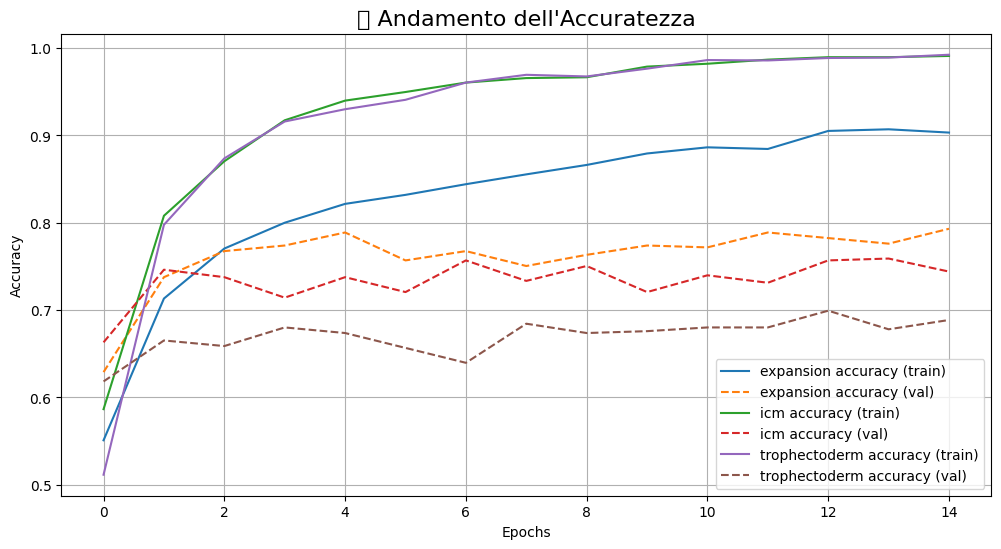

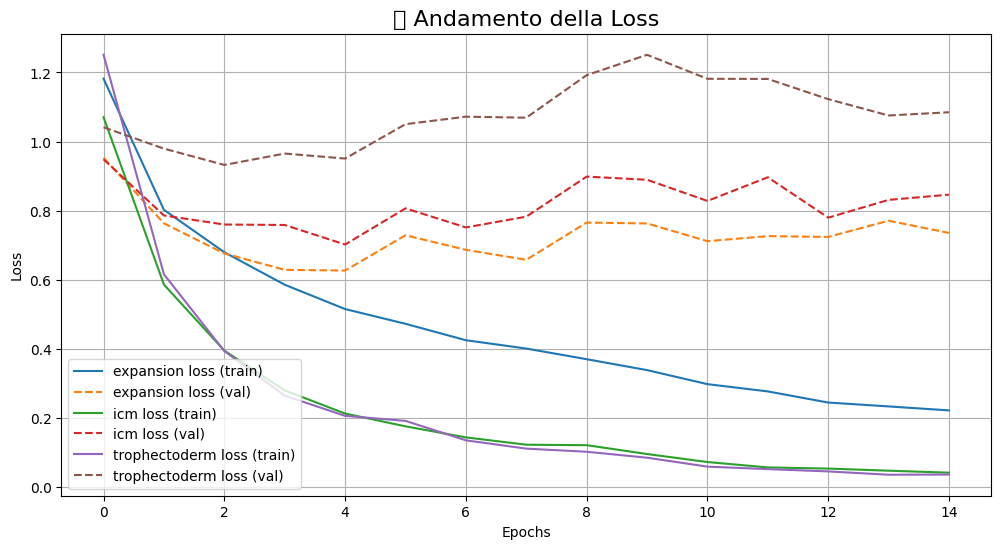

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


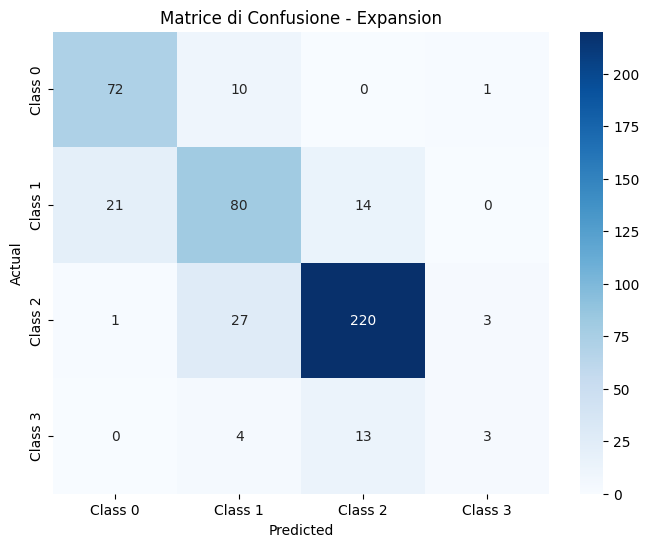

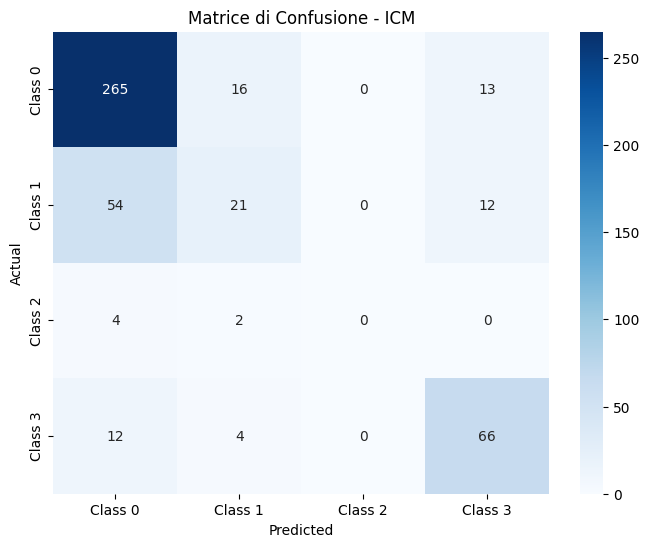

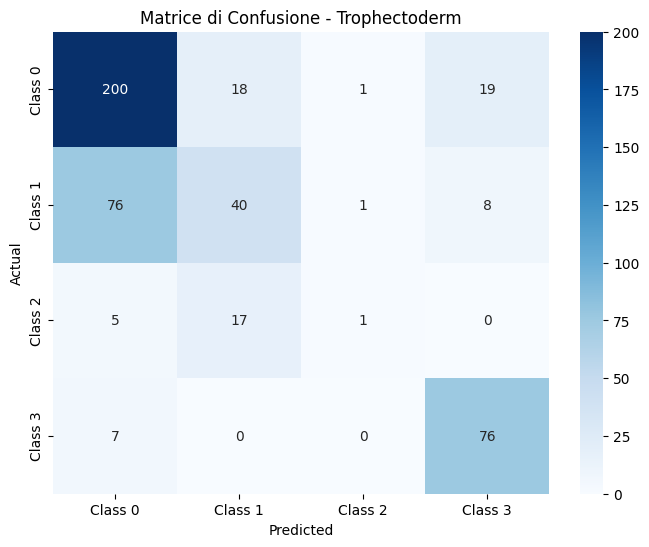


📊 Classification Report - Expansion
              precision    recall  f1-score   support

     Class 0       0.77      0.87      0.81        83
     Class 1       0.66      0.70      0.68       115
     Class 2       0.89      0.88      0.88       251
     Class 3       0.43      0.15      0.22        20

    accuracy                           0.80       469
   macro avg       0.69      0.65      0.65       469
weighted avg       0.79      0.80      0.79       469


📊 Classification Report - ICM
              precision    recall  f1-score   support

     Class 0       0.79      0.90      0.84       294
     Class 1       0.49      0.24      0.32        87
     Class 2       0.00      0.00      0.00         6
     Class 3       0.73      0.80      0.76        82

    accuracy                           0.75       469
   macro avg       0.50      0.49      0.48       469
weighted avg       0.71      0.75      0.72       469


📊 Classification Report - Trophectoderm
              precisi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Input, Dropout,
                                     BatchNormalization, RandomFlip, RandomRotation,
                                     RandomZoom, RandomContrast, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

# Input layer
input_tensor = Input(shape=(224, 224, 3))
augmented = DynamicAugmentation()(input_tensor)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model(augmented)

# Congela i pesi pre-addestrati
for layer in base_model.layers:
    layer.trainable = False

# ✅ Livelli personalizzati
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(512, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# ✅ Output layers con L2 ridotto
expansion_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.001), name='expansion')(x)
icm_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.001), name='icm')(x)
te_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.001), name='trophectoderm')(x)


model = Model(inputs=base_model.input, outputs=[expansion_output, icm_output, te_output])

# Sbloccare più layer per fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Decadimento Esponenziale del Learning Rate
def lr_schedule(epoch, lr):
    return lr * 0.95 if epoch > 5 else lr

# Compilazione
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss={
        "expansion": "sparse_categorical_crossentropy",
        "icm": "sparse_categorical_crossentropy",
        "trophectoderm": "sparse_categorical_crossentropy"
    },
    loss_weights={"expansion": 1.2, "icm": 2.0, "trophectoderm": 3.0},
    metrics={
        "expansion": ["accuracy"],
        "icm": ["accuracy"],
        "trophectoderm": ["accuracy"]
    }
)

# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

]

# Training
history_finetune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=80,
    batch_size=16,
    callbacks=callbacks
)

# Valutazione
results = model.evaluate(test_dataset, return_dict=True)
print(f"\n✅ Risultati sul test set: {results}")

# Funzione per i grafici
def plot_metrics(history, metric, title):
    plt.figure(figsize=(12, 6))
    for output in ['expansion', 'icm', 'trophectoderm']:
        plt.plot(history.history[f"{output}_{metric}"], label=f"{output} {metric} (train)")
        plt.plot(history.history[f"val_{output}_{metric}"], linestyle='--', label=f"{output} {metric} (val)")
    plt.title(f"📈 {title}", fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizzazione dei grafici
plot_metrics(history_finetune, "accuracy", "Andamento dell'Accuratezza")
plot_metrics(history_finetune, "loss", "Andamento della Loss")

# Funzione per la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Liste per le etichette reali e predette
y_true_expansion, y_pred_expansion = [], []
y_true_icm, y_pred_icm = [], []
y_true_te, y_pred_te = [], []

# Estrazione dei dati dal dataset di test
for images, labels in test_dataset:
    y_true_expansion.extend(labels["expansion"].numpy())
    y_true_icm.extend(labels["icm"].numpy())
    y_true_te.extend(labels["trophectoderm"].numpy())

    preds = model.predict(images)
    y_pred_expansion.extend(np.argmax(preds[0], axis=1))
    y_pred_icm.extend(np.argmax(preds[1], axis=1))
    y_pred_te.extend(np.argmax(preds[2], axis=1))

# Creazione delle etichette corrette
expansion_labels = [f"Class {i}" for i in range(len(set(y_true_expansion)))]
icm_labels = [f"Class {i}" for i in range(len(set(y_true_icm)))]
te_labels = [f"Class {i}" for i in range(len(set(y_true_te)))]

# Matrici di confusione
plot_confusion_matrix(y_true_expansion, y_pred_expansion, expansion_labels, "Matrice di Confusione - Expansion")
plot_confusion_matrix(y_true_icm, y_pred_icm, icm_labels, "Matrice di Confusione - ICM")
plot_confusion_matrix(y_true_te, y_pred_te, te_labels, "Matrice di Confusione - Trophectoderm")

# Report di classificazione
print("\n📊 Classification Report - Expansion")
print(classification_report(y_true_expansion, y_pred_expansion, target_names=expansion_labels))

print("\n📊 Classification Report - ICM")
print(classification_report(y_true_icm, y_pred_icm, target_names=icm_labels))

print("\n📊 Classification Report - Trophectoderm")
print(classification_report(y_true_te, y_pred_te, target_names=te_labels))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Input, Dropout,
                                     BatchNormalization, RandomFlip, RandomRotation,
                                     RandomZoom, RandomContrast, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report

tf.config.run_functions_eagerly(True)
# Input
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)

base_model.trainable = False
# Sbloccare più layer per fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Feature extraction
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)

# Tre classifier separati
expansion_output = Dense(4, activation='softmax', name='expansion')(x)
icm_output = Dense(4, activation='softmax', name='icm')(x)
te_output = Dense(4, activation='softmax', name='trophectoderm')(x)

# Creiamo tre modelli separati
model_expansion = Model(inputs=base_model.input, outputs=expansion_output)
model_icm = Model(inputs=base_model.input, outputs=icm_output)
model_te = Model(inputs=base_model.input, outputs=te_output)









In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calcola i pesi per Expansion
class_weights_expansion = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['EXP']), # Assicurati che df_train sia il tuo DataFrame di training
    y=df_train['EXP']
)
class_weights_expansion = dict(enumerate(class_weights_expansion))

# Calcola i pesi per ICM
class_weights_icm = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['ICM']),
    y=df_train['ICM']
)
class_weights_icm = dict(enumerate(class_weights_icm))

# Calcola i pesi per TE
class_weights_te = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['TE']),
    y=df_train['TE']
)
class_weights_te = dict(enumerate(class_weights_te))


print(class_weights_expansion)
print(class_weights_icm)
print(class_weights_te )

{0: np.float64(1.463598901098901), 1: np.float64(1.331875), 2: np.float64(0.5419633774160733), 3: np.float64(1.3873697916666667)}
{0: np.float64(0.3871729651162791), 1: np.float64(1.492296918767507), 2: np.float64(19.73148148148148), 3: np.float64(1.4359838274932615)}
{0: np.float64(0.46205550737207285), 1: np.float64(0.9793198529411765), 2: np.float64(8.879166666666666), 3: np.float64(1.4244652406417113)}


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_203']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.5906 - loss: 1.0955

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_203']
Received: inputs=Tensor(shape=(19, 224, 224, 3))
  warnings.warn(msg)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.5909 - loss: 1.0951

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_203']
Received: inputs=Tensor(shape=(21, 224, 224, 3))
  warnings.warn(msg)


67/67 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5912 - loss: 1.0948 - val_accuracy: 0.6098 - val_loss: 0.8837 - learning_rate: 1.0000e-04
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 70s 934ms/step - accuracy: 0.8087 - loss: 0.4718 - val_accuracy: 0.7676 - val_loss: 0.6691 - learning_rate: 1.0000e-04
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 968ms/step - accuracy: 0.9202 - loss: 0.2734 - val_accuracy: 0.7505 - val_loss: 0.8021 - learning_rate: 1.0000e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 939ms/step - accuracy: 0.9369 - loss: 0.2003 - val_accuracy: 0.7441 - val_loss: 0.7336 - learning_rate: 1.0000e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 940ms/step - accuracy: 0.9608 - loss: 0.1448 - val_accuracy: 0.7783 - val_loss: 0.6500 - learning_rate: 1.0000e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 940ms/step - accuracy: 0.9619 - loss: 0.1203 - val_accuracy: 0.7591 - val_loss: 0.6676 - learning_rate: 1.0000e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9815 - l

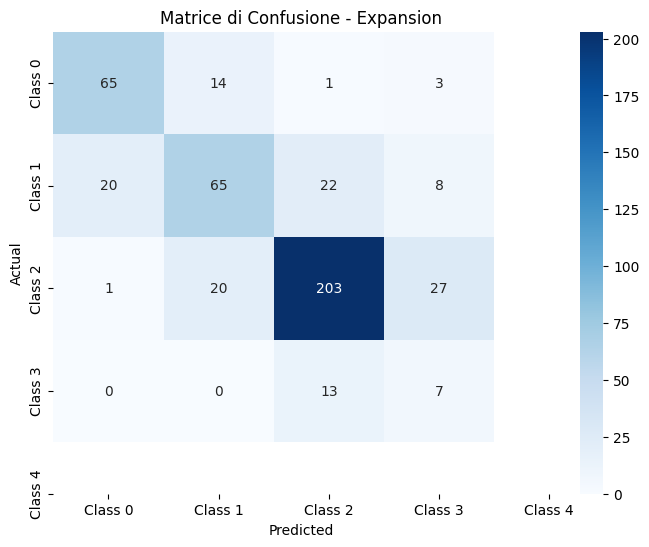

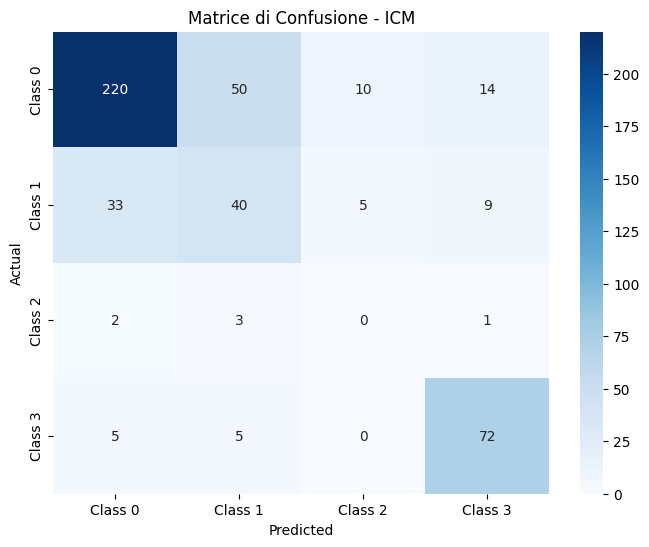

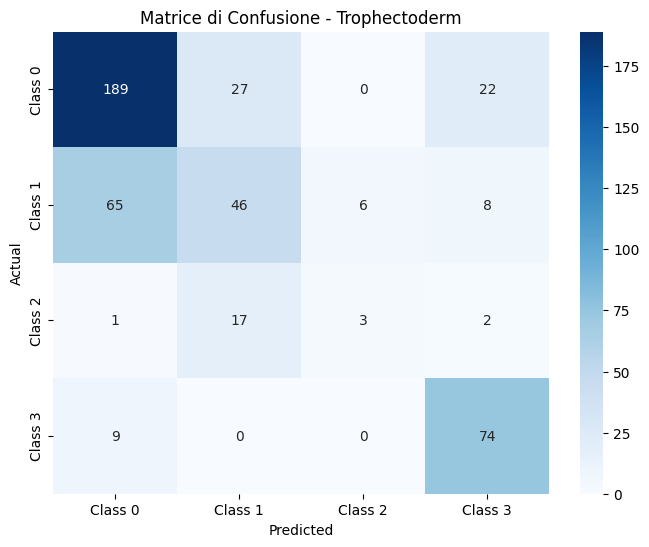


📊 Classification Report - Expansion
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        83
           1       0.66      0.57      0.61       115
           2       0.85      0.81      0.83       251
           3       0.16      0.35      0.22        20

    accuracy                           0.72       469
   macro avg       0.60      0.63      0.61       469
weighted avg       0.76      0.72      0.74       469


📊 Classification Report - ICM
              precision    recall  f1-score   support

           0       0.85      0.75      0.79       294
           1       0.41      0.46      0.43        87
           2       0.00      0.00      0.00         6
           3       0.75      0.88      0.81        82

    accuracy                           0.71       469
   macro avg       0.50      0.52      0.51       469
weighted avg       0.74      0.71      0.72       469


📊 Classification Report - Trophectoderm
              precisi

In [ ]:

# Compilazione di ogni modello
optimizer = Adam(learning_rate=1e-4)

model_expansion.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Addestramento per Expansion
history_expansion = model_expansion.fit(
    train_dataset.map(lambda x, y: (x, y["expansion"])),
    validation_data=test_dataset.map(lambda x, y: (x, y["expansion"])),
    epochs=20,
    batch_size=16,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
        ModelCheckpoint("best_model_expansion.keras", save_best_only=True, monitor='val_accuracy')  # Aggiunto ModelCheckpoint
    ],
    #class_weight=class_weights_expansion
)

# Compilazione di ogni modello
optimizer = Adam(learning_rate=1e-4)

model_icm.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Addestramento per ICM
history_icm = model_icm.fit(
    train_dataset.map(lambda x, y: (x, y["icm"])),
    validation_data=test_dataset.map(lambda x, y: (x, y["icm"])),
    epochs=20,
    batch_size=16,
       callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
        ModelCheckpoint("best_model_icm.keras", save_best_only=True, monitor='val_accuracy')  # Aggiunto ModelCheckpoint
    ],
    class_weight=class_weights_icm
)

optimizer = Adam(learning_rate=1e-4)

model_te.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Addestramento per Trophectoderm
history_te = model_te.fit(
    train_dataset.map(lambda x, y: (x, y["trophectoderm"])),
    validation_data=test_dataset.map(lambda x, y: (x, y["trophectoderm"])),
    epochs=20,
    batch_size=16,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
        ModelCheckpoint("best_model_te.keras", save_best_only=True, monitor='val_accuracy')  # Aggiunto ModelCheckpoint
    ],
    class_weight=class_weights_te
)

# Valutazione sui test set
results_expansion = model_expansion.evaluate(test_dataset.map(lambda x, y: (x, y["expansion"])))
results_icm = model_icm.evaluate(test_dataset.map(lambda x, y: (x, y["icm"])))
results_te = model_te.evaluate(test_dataset.map(lambda x, y: (x, y["trophectoderm"])))

print(f"✅ Expansion Test Accuracy: {results_expansion[1]:.4f}")
print(f"✅ ICM Test Accuracy: {results_icm[1]:.4f}")
print(f"✅ Trophectoderm Test Accuracy: {results_te[1]:.4f}")

# Funzione per matrice di confusione
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Liste per etichette reali e predette
y_true_expansion, y_pred_expansion = [], []
y_true_icm, y_pred_icm = [], []
y_true_te, y_pred_te = [], []

# Estrazione dati dal dataset di test
for images, labels in test_dataset:
    y_true_expansion.extend(labels["expansion"].numpy())
    y_true_icm.extend(labels["icm"].numpy())
    y_true_te.extend(labels["trophectoderm"].numpy())

    y_pred_expansion.extend(np.argmax(model_expansion.predict(images), axis=1))
    y_pred_icm.extend(np.argmax(model_icm.predict(images), axis=1))
    y_pred_te.extend(np.argmax(model_te.predict(images), axis=1))

# Matrici di confusione
plot_confusion_matrix(y_true_expansion, y_pred_expansion, ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], "Matrice di Confusione - Expansion")
plot_confusion_matrix(y_true_icm, y_pred_icm, ["Class 0", "Class 1", "Class 2", "Class 3"], "Matrice di Confusione - ICM")
plot_confusion_matrix(y_true_te, y_pred_te, ["Class 0", "Class 1", "Class 2", "Class 3"], "Matrice di Confusione - Trophectoderm")

# Classification Reports
print("\n📊 Classification Report - Expansion")
print(classification_report(y_true_expansion, y_pred_expansion))

print("\n📊 Classification Report - ICM")
print(classification_report(y_true_icm, y_pred_icm))

print("\n📊 Classification Report - Trophectoderm")
print(classification_report(y_true_te, y_pred_te))


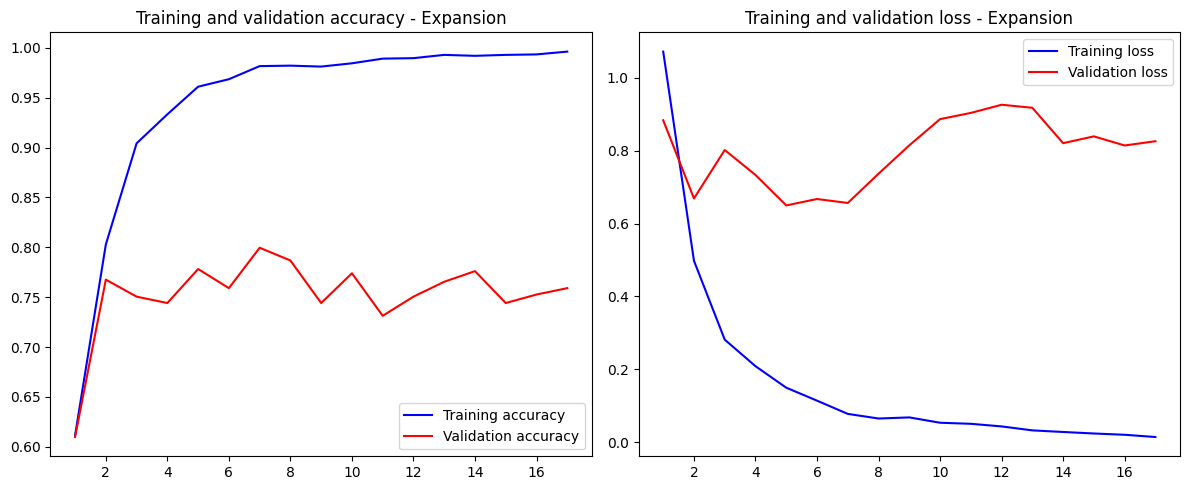

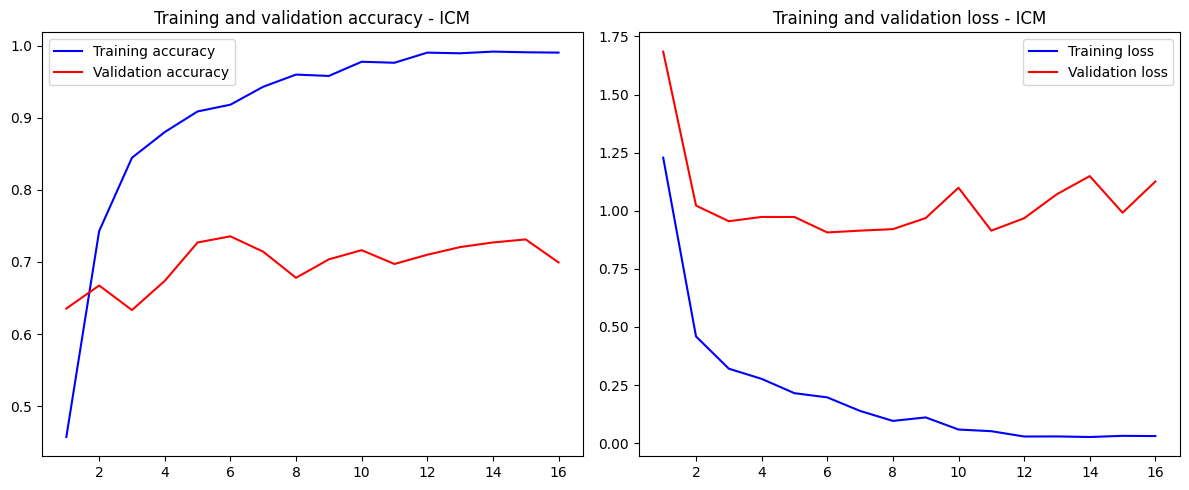

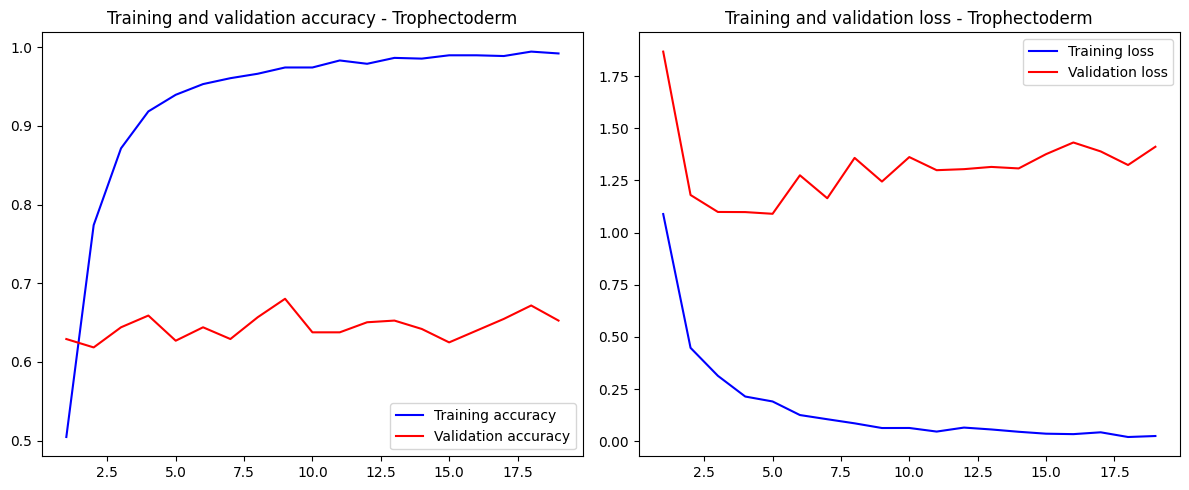

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    # Estrai i dati dalla history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Crea figura con due subplot
    plt.figure(figsize=(12, 5))

    # Grafico accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and validation accuracy - ' + title)
    plt.legend()

    # Grafico loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and validation loss - ' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizza i grafici per ogni modello
plot_training_history(history_expansion, "Expansion")
plot_training_history(history_icm, "ICM")
plot_training_history(history_te, "Trophectoderm")